In [1]:
import copy
import dataclasses
import datetime

import numpy as np
import pydantic
from scipy import optimize, stats  # type: ignore

from cr_knee_fit import experiments
from cr_knee_fit.cr_model import (
    CosmicRaysModel,
    CosmicRaysModelConfig,
    SharedPowerLawSpectrum,
    SpectralBreak,
    SpectralBreakConfig,
)
from cr_knee_fit.experiments import Experiment
from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import loglikelihood, logposterior
from cr_knee_fit.model_ import Model, ModelConfig
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts
from cr_knee_fit.elements import Element

In [2]:
E_SCALE = 2.6  # for plots only


def initial_guess_break(bc: SpectralBreakConfig, break_idx: int) -> SpectralBreak:
    if bc.fixed_lg_sharpness:
        lg_s = bc.fixed_lg_sharpness
    else:
        lg_s = stats.norm.rvs(loc=np.log10(5), scale=0.01)

    break_pos_guesses = [4.2, 5.3, 6.5]
    d_alpha_guesses = [0.3, -0.3, 0.5]

    return SpectralBreak(
        lg_break=stats.norm.rvs(loc=break_pos_guesses[break_idx], scale=0.1),
        d_alpha=stats.norm.rvs(loc=d_alpha_guesses[break_idx], scale=0.05),
        lg_sharpness=lg_s,
        fix_sharpness=bc.fixed_lg_sharpness is not None,
    )


initial_guess_lgI = {
    Element.H: -4,
    Element.He: -4.65,
    Element.C: -6.15,
    Element.O: -6.1,
    Element.Mg: -6.85,
    Element.Si: -6.9,
    Element.Fe: -6.9,
}


def initial_guess_model(config: ModelConfig) -> Model:
    return Model(
        populations=[
            CosmicRaysModel(
                base_spectra=[
                    (
                        SharedPowerLawSpectrum(
                            lgI_per_element={
                                element: stats.norm.rvs(loc=initial_guess_lgI[element], scale=0.05)
                                for element in component.elements
                            },
                            alpha=stats.norm.rvs(
                                loc=2.6 if component == [Element.H] else 2.5,
                                scale=0.05,
                            ),
                        )
                    )
                    for component in pop_config.component_configs
                ],
                breaks=[
                    initial_guess_break(bc, break_idx=i) for i, bc in enumerate(pop_config.breaks)
                ],
                all_particle_lg_shift=(
                    np.log10(stats.uniform.rvs(loc=1.1, scale=0.9))
                    if pop_config.rescale_all_particle
                    else None
                ),
                free_Z=(
                    stats.uniform.rvs(loc=14, scale=26 - 14)
                    if pop_config.has_free_Z_component
                    else None
                ),
            )
            for pop_config in config.population_configs
        ],
        energy_shifts=ExperimentEnergyScaleShifts(
            lg_shifts={exp: stats.norm.rvs(loc=0, scale=0.01) for exp in config.shifted_experiments}
        ),
    )


def safe_initial_guess_model(config: ModelConfig, fit_data: FitData) -> Model:
    n_try = 1000
    for _ in range(n_try):
        m = initial_guess_model(config)
        if np.isfinite(logposterior(m, fit_data, config)):
            return m
    else:
        raise ValueError(f"Failed to generate valid model in {n_try} tries")


class FitConfig(pydantic.BaseModel):
    name: str
    experiments_detailed: list[Experiment]
    experiments_all_particle: list[Experiment]
    experiments_lnA: list[Experiment]
    model: ModelConfig


def print_delim():
    print(
        "\n\n"
        + "=" * 15
        + "\n"
        + datetime.datetime.now().isoformat(sep=" ", timespec="seconds")
        + "\n\n"
    )


def load_fit_data(config: FitConfig) -> FitData:
    return FitData.load(
        experiments_detailed=config.experiments_detailed,
        experiments_all_particle=config.experiments_all_particle,
        experiments_lnA=config.experiments_lnA,
        elements=config.model.elements(only_fixed_Z=True),
        R_bounds=(7e2, 1e8),
    )


def run_mle(config: FitConfig) -> Model:
    fit_data = load_fit_data(config)

    mle_config = dataclasses.replace(config.model, shifted_experiments=[])

    def negloglike(v: np.ndarray) -> float:
        return -loglikelihood(v, fit_data, mle_config)

    res = optimize.minimize(
        negloglike,
        x0=safe_initial_guess_model(mle_config, fit_data).pack(),
        method="Nelder-Mead",
        options={
            "maxiter": 100_000,
        },
    )
    print(res)
    mle_model = Model.unpack(res.x, layout_info=mle_config)
    fig = mle_model.plot(fit_data, scale=E_SCALE)
    mle_model.print_params()
    fig.show()
    return mle_model

/home/njvh/Documents/Science/cr-knee-fit/cr_knee_fit/model_.py:31: UserWarning: cr_model_config class is deprecated, use population_configs
  warnings.warn("cr_model_config class is deprecated, use population_configs")


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 57.20046674145372
             x: [-4.101e+00  2.618e+00 ...  5.399e+00 -2.203e-01]
           nit: 2766
          nfev: 3761
 final_simplex: (array([[-4.101e+00,  2.618e+00, ...,  5.399e+00,
                        -2.203e-01],
                       [-4.101e+00,  2.618e+00, ...,  5.399e+00,
                        -2.203e-01],
                       ...,
                       [-4.101e+00,  2.618e+00, ...,  5.399e+00,
                        -2.203e-01],
                       [-4.101e+00,  2.618e+00, ...,  5.399e+00,
                        -2.203e-01]]), array([ 5.720e+01,  5.720e+01, ...,  5.720e+01,  5.720e+01]))
  1.                          lgI_{H} = -4.10e+00
  2.                        alpha_{H} = 2.62e+00
  3.                         lgI_{He} = -4.66e+00
  4.                       alpha_{He} = 2.51e+00
  5.                          lgI_{C} = -6.18e+00
  6.            

/tmp/ipykernel_23240/4101443889.py:131: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


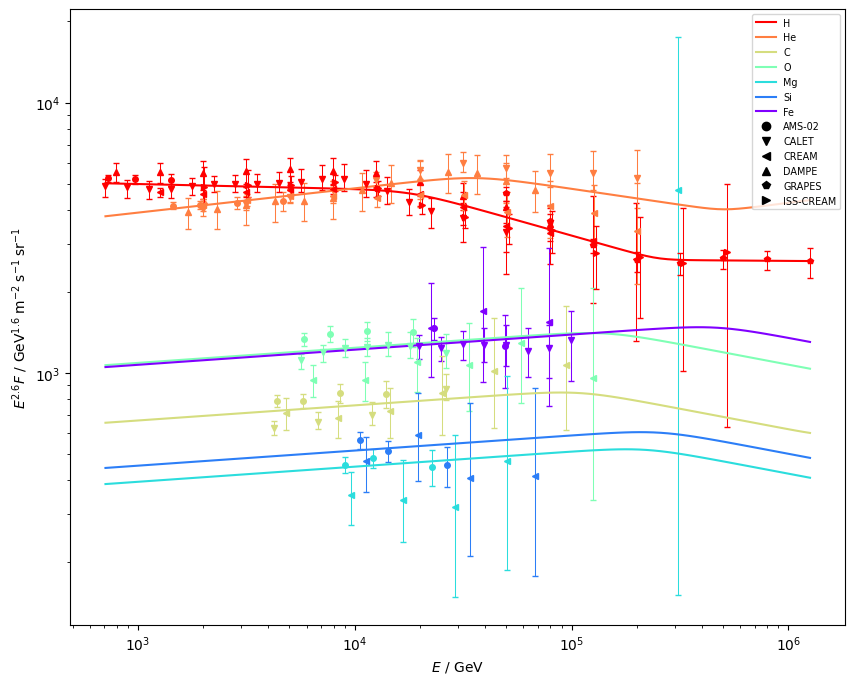

In [3]:
experiments_detailed = experiments.direct_experiments + [experiments.grapes]

mle_config = FitConfig(
    name="",
    experiments_detailed=experiments_detailed,
    experiments_all_particle=[],
    experiments_lnA=[],
    model=ModelConfig(
        cr_model_config=CosmicRaysModelConfig(
            components=[
                [Element.H],
                [Element.He],
                [
                    Element.C,
                    Element.O,
                    Element.Mg,
                    Element.Si,
                    Element.Fe,
                ],
            ],
            breaks=[
                SpectralBreakConfig(fixed_lg_sharpness=np.log10(5)),
                SpectralBreakConfig(fixed_lg_sharpness=np.log10(10)),
            ],
            rescale_all_particle=False,
        ),
        shifted_experiments=[e for e in experiments_detailed if e != experiments.ams02],
    ),
)

mle_model = run_mle(mle_config)

In [4]:
mle_model.pack()

array([-4.10089195,  2.61825639, -4.66130104,  2.51009426, -6.17747429,
       -6.15724335, -6.86917684, -6.91289062, -6.95469457,  2.54402961,
        4.25823649,  0.20784977,  5.39942303, -0.22027062])

# Fits on top of the fixed composition model

Data by element:
AMS-02
  H: 3 points from 7.3e+02 to 1.4e+03 GeV
  He: 4 points from 1.5e+03 to 4.6e+03 GeV
  C: 4 points from 4.4e+03 to 1.4e+04 GeV
  O: 4 points from 5.8e+03 to 1.9e+04 GeV
  Mg: 3 points from 9.0e+03 to 2.3e+04 GeV
  Si: 3 points from 1.1e+04 to 2.7e+04 GeV
  Fe: 2 points from 2.3e+04 to 4.9e+04 GeV
CALET
  H: 18 points from 7.1e+02 to 5.0e+04 GeV
  He: 11 points from 2.0e+03 to 2.0e+05 GeV
  C: 4 points from 4.3e+03 to 2.6e+04 GeV
  O: 7 points from 5.7e+03 to 2.6e+04 GeV
  Fe: 8 points from 2.0e+04 to 1.0e+05 GeV
DAMPE
  H: 11 points from 7.9e+02 to 7.9e+04 GeV
  He: 13 points from 1.7e+03 to 6.8e+04 GeV
CREAM
  H: 12 points from 1.3e+03 to 2.0e+05 GeV
  He: 11 points from 2.0e+03 to 2.0e+05 GeV
  C: 6 points from 4.8e+03 to 9.4e+04 GeV
  O: 6 points from 6.4e+03 to 1.3e+05 GeV
  Mg: 5 points from 9.6e+03 to 3.1e+05 GeV
  Si: 4 points from 1.1e+04 to 6.8e+04 GeV
  Fe: 3 points from 2.2e+04 to 7.9e+04 GeV
ISS-CREAM
  H: 13 points from 2.0e+03 to 5.2e+05 GeV
GRAPES

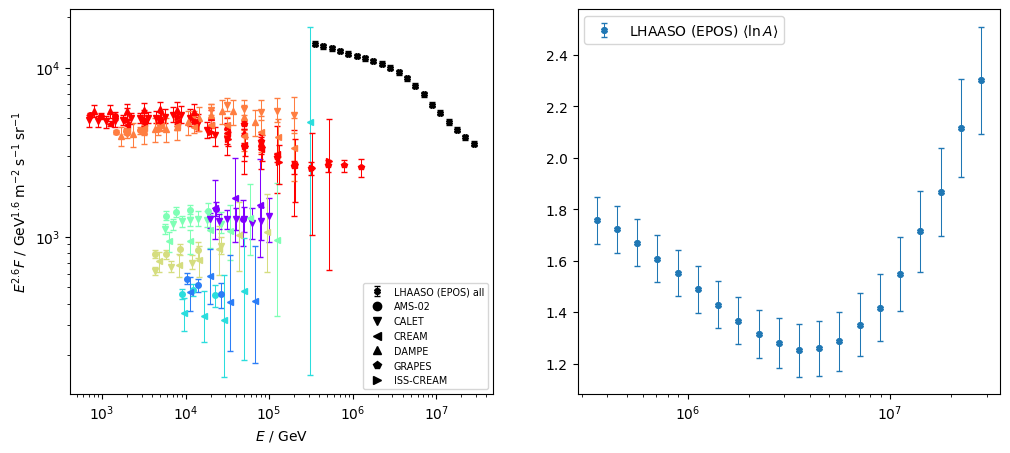

In [5]:
from cr_knee_fit.cr_model import UnresolvedElementsSpectrum


full_config = copy.deepcopy(mle_config)
full_config.experiments_all_particle = [
    # experiments.hawc,
    experiments.lhaaso_epos,
]
full_config.experiments_lnA = [experiments.lhaaso_epos]
full_fit_data = load_fit_data(full_config)

full_fit_data.plot(scale=2.6, describe=True)


def model_with_free_Z_component(theta: np.ndarray) -> Model:
    lgI_unres, lgR_knee, d_alpha_knee = theta
    model = copy.deepcopy(mle_model)
    population = model.populations[0]
    population.unresolved_elements_spectrum = UnresolvedElementsSpectrum(
        lgI=lgI_unres,
    )
    population.breaks.append(
        SpectralBreak(
            lg_break=lgR_knee,
            d_alpha=d_alpha_knee,
            lg_sharpness=np.log10(1),
        )
    )
    return model


def negloglike(theta: np.ndarray) -> float:
    return -loglikelihood(
        model_with_free_Z_component(theta),
        full_fit_data,
        None,  # type: ignore
    )

In [6]:
res = optimize.minimize(
    negloglike,
    x0=np.array(
        [
            -8,
            6.0,
            0.8,
        ]
    ),
    bounds=[
        (None, None),
        (6.0, 8.0),
        (None, None),
    ],
    method="Nelder-Mead",
    # options={
    # "maxiter": 100_000,
    # },
)
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 356.6687738429206
             x: [-6.453e+00  8.000e+00  1.867e+01]
           nit: 288
          nfev: 502
 final_simplex: (array([[-6.453e+00,  8.000e+00,  1.867e+01],
                       [-6.453e+00,  8.000e+00,  1.867e+01],
                       [-6.453e+00,  8.000e+00,  1.867e+01],
                       [-6.453e+00,  8.000e+00,  1.867e+01]]), array([ 3.567e+02,  3.567e+02,  3.567e+02,  3.567e+02]))


  1.                          lgI_{H} = -4.10e+00
  2.                        alpha_{H} = 2.62e+00
  3.                         lgI_{He} = -4.66e+00
  4.                       alpha_{He} = 2.51e+00
  5.                          lgI_{C} = -6.18e+00
  6.                          lgI_{O} = -6.16e+00
  7.                         lgI_{Mg} = -6.87e+00
  8.                         lgI_{Si} = -6.91e+00
  9.                         lgI_{Fe} = -6.95e+00
 10.         alpha_{C, O, Mg, Si, Fe} = 2.54e+00
 11.                        lg(R^b)_1 = 4.26e+00
 12.                        d_alpha_1 = 2.08e-01
 13.                        lg(R^b)_2 = 5.40e+00
 14.                        d_alpha_2 = -2.20e-01
 15.                        lg(R^b)_3 = 8.00e+00
 16.                        d_alpha_3 = 1.87e+01
 17.                          lg(s)_3 = 0.00e+00
 18.                        lgI_Unres = -6.45e+00


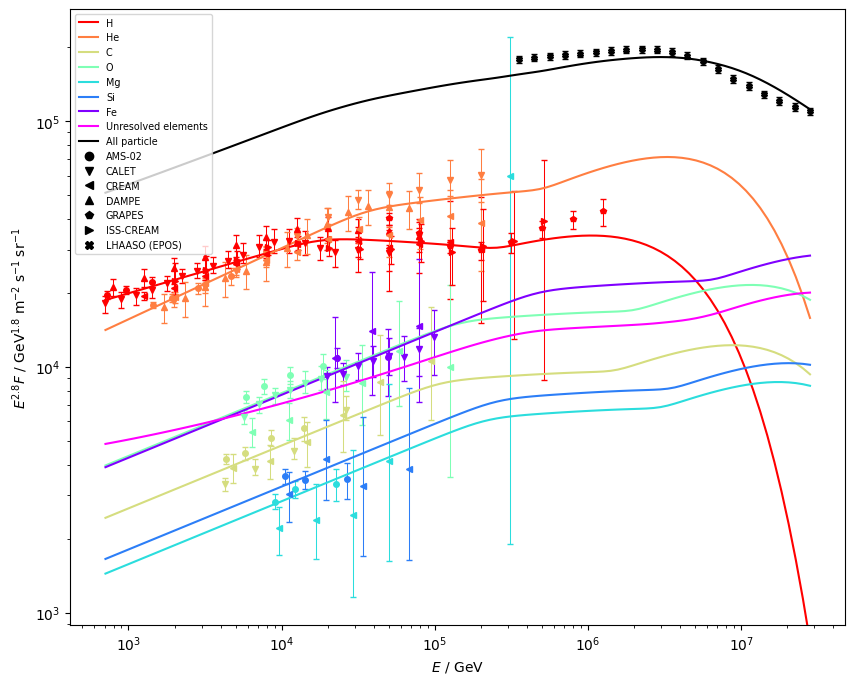

In [7]:
m = model_with_free_Z_component(res.x)
m.print_params()
_ = m.plot(full_fit_data, scale=2.8)

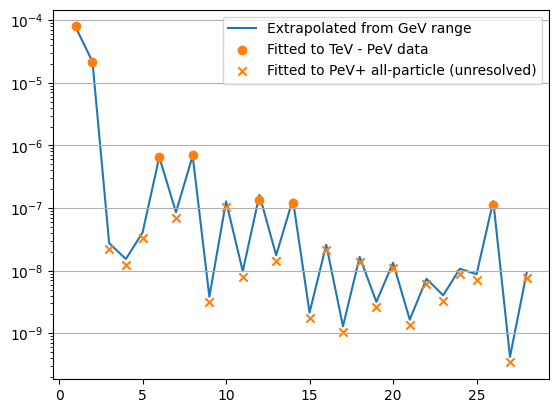

In [10]:
from matplotlib import pyplot as plt
from cr_knee_fit.elements import low_energy_CR_spectra, Z_to_element_name, unresolved_element_names

fitted_abundances = {
    el.name if isinstance(el, Element) else el: ab for el, ab in m.compute_abundances(R=1e3).items()
}

Z_grid = np.arange(1, 29, step=1, dtype=int)
pre = []
post = []
for Z in Z_grid:
    element_name = Z_to_element_name[Z]
    pre.append(low_energy_CR_spectra[element_name][0])
    post.append(fitted_abundances[element_name])
pre = np.array(pre)
post = np.array(post)

fig, ax = plt.subplots()
ax.plot(
    Z_grid,
    pre,
    label="Extrapolated from GeV range",
    zorder=-10,
)
is_unresolved_mask = np.array([Z_to_element_name[Z] in unresolved_element_names for Z in Z_grid])
ax.scatter(
    Z_grid[~is_unresolved_mask],
    post[~is_unresolved_mask],
    marker="o",
    label="Fitted to TeV - PeV data",
    color="tab:orange",
)
ax.scatter(
    Z_grid[is_unresolved_mask],
    post[is_unresolved_mask],
    marker="x",
    label="Fitted to PeV+ all-particle (unresolved)",
    color="tab:orange",
)
ax.set_yscale("log")
ax.grid(True, "major", "y")
ax.legend()